In [13]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import numpy as np
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit, vmap
from utils.clim_loss_vit import custom_loss
#from utils.clim_loss import ClimateDownscalingLoss

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)


# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

#### Data Handling: Load and Resample Data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the GMFD data to the CMIP6 resolution (e.g., ~100 km) to use as the target during training.



In [14]:
# Load the CMIP6 raw data (predictor variables)
cmip6_data_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_data = xr.open_zarr(cmip6_data_path)

cmip6_psl_path = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_psl = xr.open_zarr(cmip6_psl_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_data = xr.open_mfdataset(gmfd_files, combine='by_coords')

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_data.lat
target_lon = gmfd_data.lon
cmip6_high_res = cmip6_data.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_high_psl = cmip6_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})


def normalize(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val)

cmip6_data_norm = normalize(cmip6_high_res['tas'])
cmip6_psl_norm = normalize(cmip6_high_psl['psl'])
gmfd_data_norm = normalize(gmfd_data['tas'])


# Convert data to NumPy arrays for use in Keras
cmip6_train = cmip6_data_norm.values
cmip6_train_psl = cmip6_psl_norm.values
gmfd_train = gmfd_data_norm.values

#### Compute residuals

In [15]:
import xarray as xr

# Assuming gmfd_data and cmip6_high_res are xarray Datasets or DataArrays

# 1. Time Alignment: Normalize cmip6_high_res time to date only
cmip6_data_norm['time'] = cmip6_data_norm['time'].dt.floor('D')
residuals = gmfd_data_norm  - cmip6_data_norm

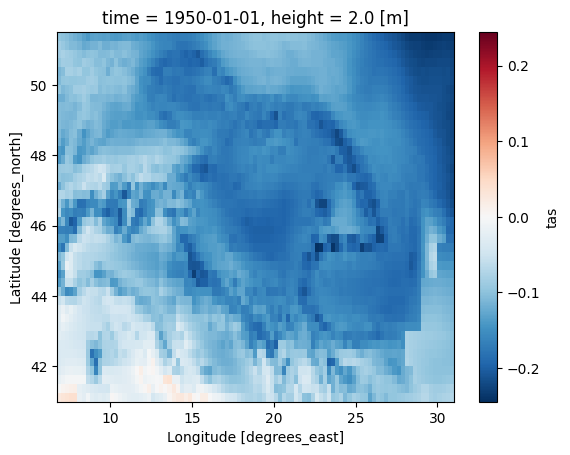

In [16]:
residuals.isel(time=0).plot()

#### Build the VIT-transformenrs (Keras with JAX Backend)


In [92]:
from keras import ops
from keras.layers import (
    Input, Dense, Dropout, MultiHeadAttention, LayerNormalization,
    Add, Conv3D, Reshape, TimeDistributed, Layer
)
from keras.models import Model, Sequential  # Added Sequential import
from keras import regularizers
from keras.saving import register_keras_serializable

# **Fourier Positional Encoding Layer** (No changes)
@register_keras_serializable()
class FourierPositionalEncoding(Layer):
    def __init__(self, embed_dim, max_freq=10, **kwargs):
        """
        Fourier positional encoding for spatial and temporal positions.
        Args:
            embed_dim: The dimension of the embeddings.
            max_freq: The maximum frequency for encoding.
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.max_freq = max_freq

    def call(self, inputs):
        """
        Compute Fourier positional encodings and add them to the inputs.
        Args:
            inputs: Input tensor of shape (batch_size, seq_len, embed_dim).
        Returns:
            Tensor with Fourier positional encodings added.
        """
        batch_size, seq_len, embed_dim = ops.shape(inputs)

        # Generate positional values (normalized between 0 and 1)
        positions = ops.linspace(0.0, 1.0, seq_len)

        # Generate frequency bands
        freq_bands = ops.power(2.0, ops.linspace(0.0, self.max_freq, self.embed_dim // 2))

        # Compute Fourier features
        encodings = ops.matmul(ops.expand_dims(positions, axis=-1), ops.expand_dims(freq_bands, axis=0))  # seq_len x (embed_dim // 2)
        sin_encodings = ops.sin(encodings)
        cos_encodings = ops.cos(encodings)

        # Concatenate sine and cosine encodings
        positional_encodings = ops.concatenate([sin_encodings, cos_encodings], axis=-1)  # seq_len x embed_dim
        positional_encodings = ops.expand_dims(positional_encodings, axis=0)  # Add batch dimension
        positional_encodings = ops.broadcast_to(positional_encodings, [batch_size, seq_len, embed_dim])

        # Add positional encodings to inputs
        return inputs + positional_encodings

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "max_freq": self.max_freq
        })
        return config

# **Residual Multi-Scale Patch Embedding Layer** (Modified num_scales handling)
@register_keras_serializable()
class ResidualMultiScalePatchEmbedding(Layer):
    def __init__(self, patch_size, embed_dim, num_scales=3, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_scales = num_scales

    def build(self, input_shape):
        self.convs = [
            Conv3D(
                filters=self.embed_dim // self.num_scales,
                kernel_size=(k, k, k),
                strides=self.patch_size,
                padding='same',
                name=f"scale_{k}x{k}x{k}"
            )
            for k in range(3, 3 + self.num_scales)  # Dynamic kernel sizes
        ]
        self.fusion = Conv3D(
            filters=self.embed_dim,
            kernel_size=1,
            strides=1,
            padding="same",
            name="multi_scale_fusion"
        )
        self.residual_proj = Conv3D(
            filters=self.embed_dim,
            kernel_size=1,
            strides=self.patch_size,
            padding="same",
            name="residual_projection"
        )

    def call(self, x):
        batch_size = ops.shape(x)[0]
        multi_scale_features = [conv(x) for conv in self.convs]
        combined_features = ops.concatenate(multi_scale_features, axis=-1)
        fused_features = self.fusion(combined_features)
        residual = self.residual_proj(x)
        fused_features += residual
        _, t, h, w, c = ops.shape(fused_features)
        return ops.reshape(fused_features, (batch_size, t * h * w, c))

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "embed_dim": self.embed_dim,
            "num_scales": self.num_scales
        })
        return config

# **Spatial-Temporal Attention Block** (Simplified with unified attention)
@register_keras_serializable()
class SpatialTemporalAttentionBlock(Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout, weight_decay, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout
        self.weight_decay = weight_decay

    def build(self, input_shape):
        # Unified Spatial-Temporal Attention
        self.attention = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embed_dim // self.num_heads,
            dropout=self.dropout
        )
        # Layer normalizations
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # Feed-forward network (MLP)
        self.mlp = Sequential([
            Dense(self.mlp_dim, activation="gelu", kernel_regularizer=regularizers.L2(self.weight_decay)),
            Dropout(self.dropout),
            Dense(self.embed_dim, kernel_regularizer=regularizers.L2(self.weight_decay)),
            Dropout(self.dropout)
        ])

    def call(self, inputs):
        attn_output = self.attention(inputs, inputs)  # Unified attention
        x = Add()([inputs, attn_output])
        x = self.layernorm1(x)

        # Feed-forward network (MLP)
        mlp_output = self.mlp(x)
        return self.layernorm2(Add()([x, mlp_output]))

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "mlp_dim": self.mlp_dim,
            "dropout": self.dropout,
            "weight_decay": self.weight_decay
        })
        return config

# **ViT Transformer** (Modified with dynamic output units and other improvements)
def vit_transformer(input_shape, patch_size, embed_dim, num_heads, transformer_layers, mlp_dim, dropout, weight_decay):
    inputs = Input(shape=input_shape)

    # Residual Multi-Scale Patch Embedding
    x = ResidualMultiScalePatchEmbedding(patch_size=patch_size, embed_dim=embed_dim, num_scales=3)(inputs)

    # Add Fourier positional encoding
    x = FourierPositionalEncoding(embed_dim=embed_dim, max_freq=10)(x)

    # Spatial-Temporal Transformer layers
    for _ in range(transformer_layers):
        x = SpatialTemporalAttentionBlock(
            embed_dim=embed_dim,
            num_heads=num_heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            weight_decay=weight_decay
        )(x)

    # Reshape to (batch_size, time_steps, features)
    num_time_steps = input_shape[0]
    _, num_patches, embed_dim = ops.shape(x)
    num_spatial_patches = num_patches // num_time_steps
    x = Reshape((num_time_steps, num_spatial_patches * embed_dim))(x)

    # TimeDistributed Dense layers for regression at each time step
    x = TimeDistributed(Dense(units=mlp_dim // 2, activation="gelu", kernel_regularizer=regularizers.L2(weight_decay)))(x)  # Reduced units
    x = TimeDistributed(Dropout(dropout))(x)

    # Final TimeDistributed Dense layer with dynamically calculated units
    total_units_per_timestep = input_shape[1] * input_shape[2] * 1  # Last dim is 1
    x = TimeDistributed(Dense(units=total_units_per_timestep, activation="linear", kernel_regularizer=regularizers.L2(weight_decay)))(x)

    # Reshape to match the target output shape for each time step
    x = TimeDistributed(Reshape(target_shape=(input_shape[1], input_shape[2], 1)))(x)
    outputs = x

    return Model(inputs, outputs)

# **Example Usage** (Adjusted input shape and num_scales)
input_shape = (7, 42, 97, 2)  # Changed width to 98 to be divisible by patch size
patch_size = (1, 7, 7)
num_scales = 3  # Corrected

model = vit_transformer(
    input_shape=input_shape,
    patch_size=patch_size,
    embed_dim=128,
    num_heads=4,
    transformer_layers=2,
    mlp_dim=64,
    dropout=0.1,
    weight_decay=0.01
)

model.summary()

Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_66 (InputLayer)     │ (None, 7, 42, 97, 2)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_multi_scale_patch_emb… │ (None, 588, 128)       │        34,910 │
│ (ResidualMultiScalePatchEmbedd… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fourier_positional_encoding_16  │ (None, 588, 128)       │             0 │
│ (FourierPositionalEncoding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_22 (Cast)                  │ (None, 588, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 588, 128)       │        83,136 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 588, 128)       │        83,136 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_30 (Reshape)            │ (None, 7, 10752)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_52             │ (None, 7, 32)          │       344,096 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_53             │ (None, 7, 32)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_54             │ (None, 7, 4074)        │       134,442 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_55             │ (None, 7, 42, 97, 1)   │             0 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 679,720 (2.59 MB)

 Trainable params: 679,720 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

#### Split the data
Train set: The first portion of the time period (e.g., 60% of the time series).
Validation set: The next portion of the time series (e.g., the following 20% of the time series).
Test set: The final portion of the time series (e.g., the last 20%): 

In [18]:
import pandas as pd
index_2004 = int(np.where(cmip6_data_norm.time.values == pd.to_datetime('2004-12-31'))[0][0])
index_2009 = int(np.where(cmip6_data_norm.time.values == pd.to_datetime('2009-12-31'))[0][0])

In [19]:
# Reshape data to add the channel dimension
cmip6_train_reshaped = cmip6_train[..., np.newaxis]
cmip6_train_slp_reshaped = cmip6_train_psl[..., np.newaxis]

# Concatenate the reshaped arrays along the last axis
cmip6_train_combined = np.concatenate((cmip6_train_reshaped, cmip6_train_slp_reshaped), axis=-1)

gmfd_train_reshaped = gmfd_train[..., np.newaxis]
residual_reshaped = residuals.values[..., np.newaxis]

# Split the data while preserving the temporal structure
X_train = cmip6_train_combined[:index_2004]
y_train = gmfd_train_reshaped[:index_2004]
res_train = residual_reshaped[:index_2004]

X_val = cmip6_train_combined[index_2004:index_2009]
y_val = gmfd_train_reshaped[index_2004:index_2009]
res_val =  residual_reshaped[index_2004:index_2009]

X_test = cmip6_train_combined[index_2009:]
y_test = gmfd_train_reshaped[index_2009:]
res_test = residual_reshaped[index_2009:]


# # Reshape X data to include the temporal dimension
# X_train = np.expand_dims(X_train, axis=1)
# X_val = np.expand_dims(X_val, axis=1)
# X_test = np.expand_dims(X_test, axis=1)

# # Reshape y data to include the temporal dimension
# y_train = np.expand_dims(y_train, axis=1)
# y_val = np.expand_dims(y_val, axis=1)
# y_test = np.expand_dims(y_test, axis=1)

# # Reshape y data to include the temporal dimension
# res_train = np.expand_dims(res_train, axis=1)
# res_val = np.expand_dims(res_val, axis=1)
# res_test = np.expand_dims(res_test, axis=1)


In [20]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(res_train.shape)
print(res_val.shape)
print(res_test.shape)

(20088, 42, 97, 2)
(1826, 42, 97, 2)
(1827, 42, 97, 2)
(20088, 42, 97, 1)
(1826, 42, 97, 1)
(1827, 42, 97, 1)


#### Create temporal sequences

In [21]:
def create_temporal_sequences_centered(data, window_size):
    total_seq_length = 2 * window_size + 1
    sequences = []
    
    # For all time points
    for i in range(len(data)):
        sequence = np.zeros((total_seq_length,) + data.shape[1:])
        
        # Handle past values
        for j in range(window_size):
            if i - j >= 0:  # If we have data for this past point
                sequence[window_size - j] = data[i - j]
            else:  # If we don't have data, use the earliest available
                sequence[window_size - j] = data[0]
        
        # Current value
        sequence[window_size] = data[i]
        
        # Handle future values
        for j in range(window_size):
            if i + j + 1 < len(data):  # If we have data for this future point
                sequence[window_size + j + 1] = data[i + j + 1]
            else:  # If we don't have data, use the last available
                sequence[window_size + j + 1] = data[-1]
        
        sequences.append(sequence)
    
    return np.array(sequences)

window_size = 3

In [22]:
X_train_seq = create_temporal_sequences_centered(X_train, window_size)  
X_val_seq = create_temporal_sequences_centered(X_val, window_size)      
X_test_seq = create_temporal_sequences_centered(X_test, window_size)     
y_train_seq = create_temporal_sequences_centered(y_train, window_size) 
y_val_seq = create_temporal_sequences_centered(y_val, window_size)     
y_test_seq = create_temporal_sequences_centered(y_test, window_size)   

res_train_seq = create_temporal_sequences_centered(res_train, window_size) 
res_val_seq = create_temporal_sequences_centered(res_val, window_size)     
res_test_seq = create_temporal_sequences_centered(res_test, window_size) 

print("X_train shape:", X_train_seq.shape)
print("X_val_seq shape:", X_val_seq.shape)
print("y_train shape:", y_train_seq.shape)
print("y_val shape:", y_val_seq.shape)


X_train shape: (20088, 7, 42, 97, 2)
X_val_seq shape: (1826, 7, 42, 97, 2)
y_train shape: (20088, 7, 42, 97, 1)
y_val shape: (1826, 7, 42, 97, 1)


#### Train the model

In [23]:
from keras import ops
from keras.losses import Loss
from keras.saving import register_keras_serializable

@register_keras_serializable()
class ClimateDownscalingLoss(Loss):
    def __init__(self, spatial_weight=1.0, gradient_weight=0.5, temporal_weight=0.3, **kwargs):
        super().__init__(**kwargs)
        self.spatial_weight = spatial_weight
        self.gradient_weight = gradient_weight
        self.temporal_weight = temporal_weight

    def call(self, y_true, y_pred):
        # 1. Mean Squared Error (base loss)
        mse_loss = ops.mean(ops.square(y_true - y_pred))

        # 2. Spatial Gradient Loss
        def spatial_gradients(x):
            # Calculate gradients in spatial dimensions (height and width)
            # For height gradient
            dy = x[:, :, 1:, :, :] - x[:, :, :-1, :, :]
            # For width gradient
            dx = x[:, :, :, 1:, :] - x[:, :, :, :-1, :]
            return dy, dx

        # 3. Temporal Gradient Loss
        def temporal_gradients(x):
            # Calculate gradients in temporal dimension
            dt = x[:, 1:, :, :, :] - x[:, :-1, :, :, :]
            return dt

        # Calculate spatial gradients
        true_dy, true_dx = spatial_gradients(y_true)
        pred_dy, pred_dx = spatial_gradients(y_pred)
        
        spatial_gradient_loss = (ops.mean(ops.square(true_dy - pred_dy)) + 
                               ops.mean(ops.square(true_dx - pred_dx)))

        # Calculate temporal gradients
        true_dt = temporal_gradients(y_true)
        pred_dt = temporal_gradients(y_pred)
        
        temporal_gradient_loss = ops.mean(ops.square(true_dt - pred_dt))

        # Combine all losses
        total_loss = (self.spatial_weight * mse_loss + 
                     self.gradient_weight * spatial_gradient_loss +
                     self.temporal_weight * temporal_gradient_loss)
        
        return total_loss

    def get_config(self):
        config = super().get_config()
        config.update({
            "spatial_weight": self.spatial_weight,
            "gradient_weight": self.gradient_weight,
            "temporal_weight": self.temporal_weight
        })
        return config

In [68]:
import tensorflow as tf
from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN


# Input and target shapes
input_shape = (7, 42, 97, 2)
patch_size = (7, 7, 16)

# Build the model
model = vit_transformer(
    input_shape=input_shape,
    patch_size=patch_size,
    embed_dim=128,
    num_heads=4,
    transformer_layers=2,
    mlp_dim=64,
    dropout=0.3,
    weight_decay=0.2
)
# Learning rate schedule using CosineDecayRestarts
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=50,  # Number of steps in the first cycle
    t_mul=2.0,             # Cycle length multiplier
    m_mul=0.8,             # Multiplier for the max learning rate
    alpha=1e-6             # Minimum learning rate
)

# Optimizer with learning rate schedule
optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-5)


# Loss function for climate downscaling
climate_loss = ClimateDownscalingLoss(
    spatial_weight=1.0,    # Weight for MSE loss
    gradient_weight=0.5,   # Weight for spatial gradient loss
    temporal_weight=0.3    # Weight for temporal gradient loss
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=climate_loss,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Custom callback to log learning rate
class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f'\nLearning rate for epoch {epoch+1} is {lr}')

# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    ModelCheckpoint(
        filepath='models/vit_transformer_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    TerminateOnNaN(),
    LRLogger()  # Add the learning rate logger
]

# Training parameters
epochs = 500
batch_size = 32

# Perform training
history = model.fit(
    X_train_seq, res_train_seq,
    validation_data=(X_val_seq, res_val_seq),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1,
    shuffle=False  # Sequential data training
)

# Summarize results
print("\nTraining completed.")
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")


Epoch 1/500
628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 78.2222 - mean_absolute_error: 0.0650 - root_mean_squared_error: 0.0872
Epoch 1: val_loss improved from inf to 53.30907, saving model to models/vit_transformer_best_model.keras

Learning rate for epoch 1 is 1.0879954667826524e-05
628/628 ━━━━━━━━━━━━━━━━━━━━ 164s 108ms/step - loss: 78.2063 - mean_absolute_error: 0.0649 - root_mean_squared_error: 0.0872 - val_loss: 53.3091 - val_mean_absolute_error: 0.0553 - val_root_mean_squared_error: 0.0751
Epoch 2/500
619/628 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.0180 - mean_absolute_error: 0.0539 - root_mean_squared_error: 0.0741
Epoch 2: val_loss improved from 53.30907 to 37.94529, saving model to models/vit_transformer_best_model.keras

Learning rate for epoch 2 is 1.2199130964528144e-05
628/628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 49.9458 - mean_absolute_error: 0.0539 - root_mean_squared_error: 0.0741 - val_loss: 37.9453 - val_mean_absolute_error: 0.0547 - val_root_mean_squ

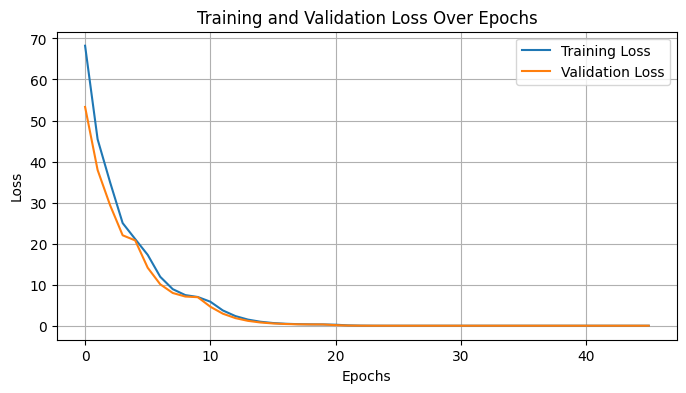

In [69]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
plt.figure(figsize=(8, 4))

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Title and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Optional: Set y-axis limits
#plt.ylim(0, 0.1)

# Show legend
plt.legend()

# Add grid for clarity
plt.grid()

# Show the plot
plt.show()


#### Evaluate the model on validation data

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Load the model

from keras.models import load_model

model_saved = load_model('models/vit_transformer_best_model.keras')

In [71]:
# Get the mean and std from the training set for denormalization
cmip6_high_res_min = cmip6_high_res['tas'].min().values
cmip6_high_res_max = cmip6_high_res['tas'].max().values

# Get the mean and std from the training set for denormalization
gmfd_min = gmfd_data['tas'].min().values
gmfd_max = gmfd_data['tas'].max().values


# Generate predictions on validation data
y_pred = model_saved.predict(X_test_seq)
print(y_pred.shape)
print(res_val_seq.shape)
print(res_test_seq.shape)

58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step
(1827, 7, 42, 97, 1)
(1826, 7, 42, 97, 1)
(1827, 7, 42, 97, 1)


In [72]:
print(X_test_seq[:,window_size,:,:,0].shape)
print(y_pred[:,window_size,:,:,0].shape)

(1827, 42, 97)
(1827, 42, 97)


In [73]:
# put back the residuals
y_pred = X_test_seq[:,window_size,:,:,0] +  y_pred[:,window_size,:,:,0]




In [74]:
print(y_pred.shape)
print(y_test_seq[:,window_size,:,:,0].shape)

(1827, 42, 97)
(1827, 42, 97)


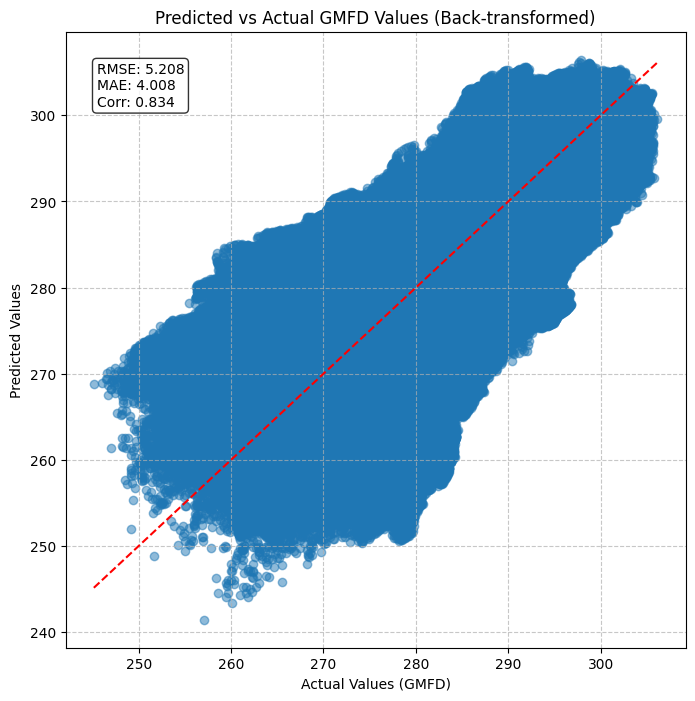

In [75]:
# Back-transform the predictions for evaluation
y_test_denorm = y_test_seq[:,window_size,:,:,0] * (gmfd_max - gmfd_min) + gmfd_min
y_pred_denorm = y_pred * (cmip6_high_res_max - cmip6_high_res_min) + cmip6_high_res_min


# Calculate RMSE, MAE, and correlation
rmse = np.sqrt(mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten()))
mae = mean_absolute_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
correlation = np.corrcoef(y_test_denorm.flatten(), y_pred_denorm.flatten())[0,1]

# Create the plot
plt.figure(figsize=(8, 8))
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid
plt.scatter(y_test_denorm.flatten(), y_pred_denorm.flatten(), alpha=0.5)
plt.xlabel('Actual Values (GMFD)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual GMFD Values (Back-transformed)')
plt.plot([y_test_denorm.min(), y_test_denorm.max()], 
         [y_test_denorm.min(), y_test_denorm.max()], 'r--')

# Add RMSE, MAE, and correlation text to the upper left
plt.text(0.05, 0.95, f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nCorr: {correlation:.3f}',  
         transform=plt.gca().transAxes, 
         verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

#### Train the on All Data
Train the model on all the data (no splitting)

In [76]:
X_all = np.concatenate((X_train_seq, X_val_seq, X_test_seq), axis=0)
y_all = np.concatenate((y_train_seq, y_val_seq, y_test_seq), axis=0)
res_all = np.concatenate((res_train_seq, res_val_seq, res_test_seq), axis=0)

In [77]:
import tensorflow as tf
from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN

# Input and target shapes
input_shape = (7, 42, 97, 2)
patch_size = (7, 7, 16)

# Build the model
model = vit_transformer(
    input_shape=input_shape,
    patch_size=patch_size,
    embed_dim=128,
    num_heads=4,
    transformer_layers=2,
    mlp_dim=64,
    dropout=0.3,
    weight_decay=0.2
)
# Learning rate schedule using CosineDecayRestarts
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=50,  # Number of steps in the first cycle
    t_mul=2.0,             # Cycle length multiplier
    m_mul=0.8,             # Multiplier for the max learning rate
    alpha=1e-6             # Minimum learning rate
)

# Optimizer with learning rate schedule
optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-5)



# Loss function for climate downscaling
climate_loss = ClimateDownscalingLoss(
    spatial_weight=1.0,    # Weight for MSE loss
    gradient_weight=0.5,   # Weight for spatial gradient loss
    temporal_weight=0.3    # Weight for temporal gradient loss
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=climate_loss,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Custom callback to log learning rate
class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f'\nLearning rate for epoch {epoch+1} is {lr}')

# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    ModelCheckpoint(
        filepath='models/vit_transformer_final_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    TerminateOnNaN(),
    LRLogger()  # Add the learning rate logger
]

# Training parameters
epochs = 500
batch_size = 32

# Perform training
history = model.fit(
    X_all, res_all,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1,
    shuffle=False  # Sequential data training
)

# Summarize results
print("\nTraining completed.")
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")


Epoch 1/500
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 78.4919 - mean_absolute_error: 0.0627 - root_mean_squared_error: 0.0844
Epoch 1: val_loss improved from inf to 53.63340, saving model to models/vit_transformer_final_model.keras

Learning rate for epoch 1 is 1.6928392313411298e-05
594/594 ━━━━━━━━━━━━━━━━━━━━ 63s 91ms/step - loss: 78.4756 - mean_absolute_error: 0.0627 - root_mean_squared_error: 0.0844 - val_loss: 53.6334 - val_mean_absolute_error: 0.0549 - val_root_mean_squared_error: 0.0746
Epoch 2/500
589/594 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.7135 - mean_absolute_error: 0.0539 - root_mean_squared_error: 0.0741
Epoch 2: val_loss improved from 53.63340 to 38.55768, saving model to models/vit_transformer_final_model.keras

Learning rate for epoch 2 is 1.7435271118602468e-05
594/594 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 50.6711 - mean_absolute_error: 0.0539 - root_mean_squared_error: 0.0741 - val_loss: 38.5577 - val_mean_absolute_error: 0.0544 - val_root_mean_squ

#### Pred on historical data

In [78]:
from keras.models import load_model
model_saved = load_model('models/vit_transformer_final_model.keras')


In [79]:
predicted_high_res = model_saved.predict(X_all)


742/742 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step


In [80]:
print(predicted_high_res[:,window_size,:,:,:1] .shape)
print(cmip6_train_reshaped.shape)

(23741, 42, 97, 1)
(23741, 42, 97, 1)


In [81]:

# Get the mean and std from the training set for denormalization
cmip6_high_res_min = cmip6_high_res['tas'].min().values
cmip6_high_res_max = cmip6_high_res['tas'].max().values

# put back the residuals
predicted_high_res = cmip6_train_reshaped +  predicted_high_res[:,window_size,:,:,:1]


In [82]:
print(predicted_high_res.shape)

(23741, 42, 97, 1)


In [83]:
#Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_high_res_max- cmip6_high_res_min) +cmip6_high_res_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)
predicted_high_res_final.shape

(23741, 42, 97)

In [84]:
# Inverse transform the predictions to get the actual temperature values


# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_high_res_max- cmip6_high_res_min) +cmip6_high_res_min


# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=gmfd_data.dims, coords=gmfd_data.coords, name='tas_downscaled')
# interpolate to the original observational data
predicted_ds = predicted_ds.interp(lat=gmfd_data.coords['lat'], lon=gmfd_data.coords['lon'], method='cubic')


predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_tas_vit.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.


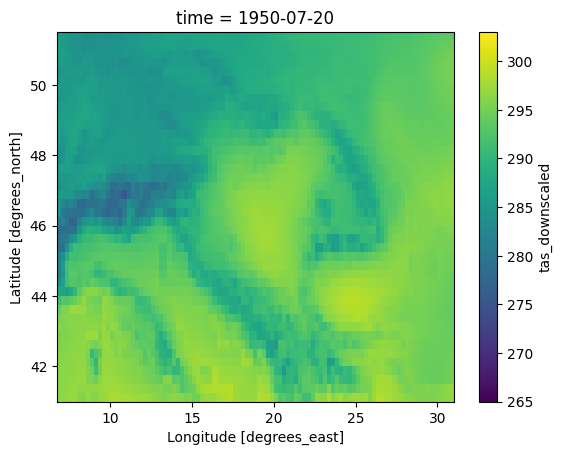

In [85]:
#Select the first time step
first_time_step = predicted_ds.isel(time=200).compute()  # Use .compute() if using Dask
first_time_step.plot(vmin=265, vmax=303)

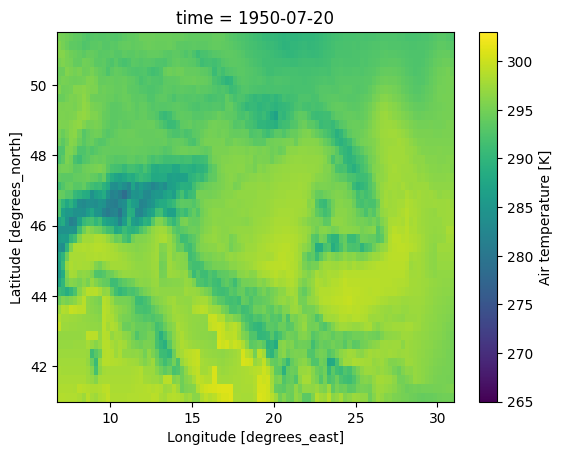

In [86]:
#Select the first time step
first_time_step = gmfd_data.isel(time=200).compute()  # Use .compute() if using Dask
first_time_step.tas.plot(vmin=265, vmax=303)

### Scenario data

#### SSP 126

982/982 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
Downscaled high-resolution predictions saved to NetCDF format.


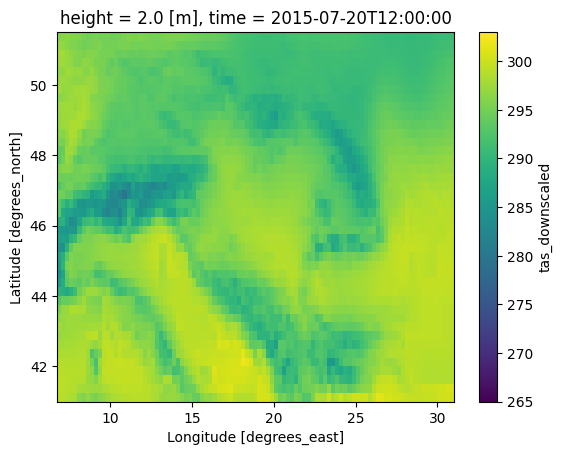

In [87]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp126 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp126 = xr.open_zarr(cmip6_ssp126)
cmip6_sp126_high_res = cmip6_ssp126.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp126_reshaped_min = cmip6_sp126_high_res['tas'].min().values
cmip6_sp126_reshaped_max = cmip6_sp126_high_res['tas'].max().values
cmip6_sp126_norm = normalize(cmip6_sp126_high_res['tas'])
cmip6_sp126_norm = cmip6_sp126_norm.values
cmip6_sp126_norm_reshaped = cmip6_sp126_norm[..., np.newaxis]


cmip6_sp126_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp126_psl = xr.open_zarr(cmip6_sp126_psl)
cmip6_sp126_psl_high_res = cmip6_sp126_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

cmip6_sp126_psl_norm = normalize(cmip6_sp126_psl_high_res['psl'])
cmip6_sp126_psl_norm = cmip6_sp126_psl_norm.values
cmip6_sp126_psl_reshaped = cmip6_sp126_psl_norm[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp126_norm_reshaped, cmip6_sp126_psl_reshaped), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 
predicted_high_res = model_saved.predict(X_scen)
predicted_high_res = cmip6_sp126_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]

# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_sp126_reshaped_max- cmip6_sp126_reshaped_min) + cmip6_sp126_reshaped_min

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp126_high_res['tas'].shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=cmip6_sp126_high_res['tas'].dims, coords=cmip6_sp126_high_res['tas'].coords, name='tas_downscaled')

predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_tas_vit_ssp126.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")
first_time_step = predicted_ds.isel(time=200).compute()  # Use .compute() if using Dask
first_time_step.plot(vmin=265, vmax=303)


#### SSP 245

982/982 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Downscaled high-resolution predictions saved to NetCDF format.


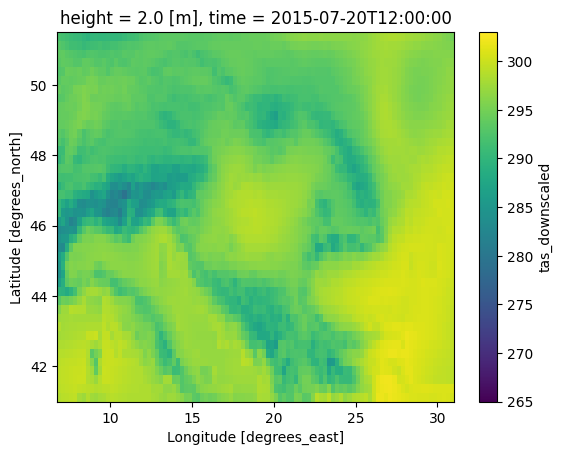

In [88]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp245 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp245 = xr.open_zarr(cmip6_ssp245)
cmip6_sp245_high_res = cmip6_ssp245.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp245_reshaped_min = cmip6_sp245_high_res['tas'].min().values
cmip6_sp245_reshaped_max = cmip6_sp245_high_res['tas'].max().values
cmip6_sp245_norm = normalize(cmip6_sp245_high_res['tas'])
cmip6_sp245_norm = cmip6_sp245_norm.values
cmip6_sp245_norm_reshaped = cmip6_sp245_norm[..., np.newaxis]


cmip6_sp245_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp245_psl = xr.open_zarr(cmip6_sp245_psl)
cmip6_sp245_psl_high_res = cmip6_sp245_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

cmip6_sp245_psl_norm = normalize(cmip6_sp245_psl_high_res['psl'])
cmip6_sp245_psl_norm = cmip6_sp245_psl_norm.values
cmip6_sp245_psl_reshaped = cmip6_sp245_psl_norm[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp245_norm_reshaped, cmip6_sp245_psl_reshaped), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 
predicted_high_res = model_saved.predict(X_scen)
predicted_high_res = cmip6_sp245_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]

# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_sp245_reshaped_max- cmip6_sp245_reshaped_min) + cmip6_sp245_reshaped_min

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp245_high_res['tas'].shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=cmip6_sp245_high_res['tas'].dims, coords=cmip6_sp245_high_res['tas'].coords, name='tas_downscaled')

predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_tas_vit_ssp245.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")
first_time_step = predicted_ds.isel(time=200).compute()  # Use .compute() if using Dask
first_time_step.plot(vmin=265, vmax=303)


#### SSP 585

982/982 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Downscaled high-resolution predictions saved to NetCDF format.


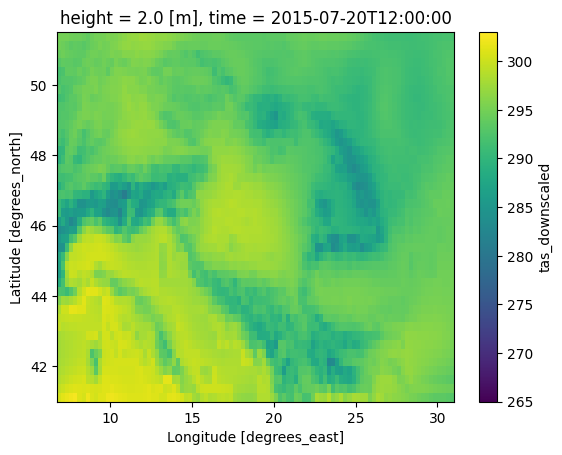

In [89]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp585 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp585 = xr.open_zarr(cmip6_ssp585)
cmip6_sp585_high_res = cmip6_ssp585.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp585_reshaped_min = cmip6_sp585_high_res['tas'].min().values
cmip6_sp585_reshaped_max = cmip6_sp585_high_res['tas'].max().values
cmip6_sp585_norm = normalize(cmip6_sp585_high_res['tas'])
cmip6_sp585_norm = cmip6_sp585_norm.values
cmip6_sp585_norm_reshaped = cmip6_sp585_norm[..., np.newaxis]


cmip6_sp585_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp585_psl = xr.open_zarr(cmip6_sp585_psl)
cmip6_sp585_psl_high_res = cmip6_sp585_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

cmip6_sp585_psl_norm = normalize(cmip6_sp585_psl_high_res['psl'])
cmip6_sp585_psl_norm = cmip6_sp585_psl_norm.values
cmip6_sp585_psl_reshaped = cmip6_sp585_psl_norm[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp585_norm_reshaped, cmip6_sp585_psl_reshaped), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 
predicted_high_res = model_saved.predict(X_scen)
predicted_high_res = cmip6_sp585_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]

# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res * (cmip6_sp585_reshaped_max- cmip6_sp585_reshaped_min) + cmip6_sp585_reshaped_min

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp585_high_res['tas'].shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=cmip6_sp585_high_res['tas'].dims, coords=cmip6_sp585_high_res['tas'].coords, name='tas_downscaled')

predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_tas_vit_ssp585.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")
first_time_step = predicted_ds.isel(time=200).compute()  # Use .compute() if using Dask
first_time_step.plot(vmin=265, vmax=303)
